# Decoding of Macaque kinematics with MARBLE embeddings

This notebook takes the outputs from training MARBLE on macaque data with 20ms bin of spiking rates. It then performs decoding of the kinematic results provided publicly by the LFADS authors.


There are three main results files of interest, differing only in the output dimension of the MARBLE architecture:
1. Marble trained with 3-dim output dimension: marble_embeddings_20ms_out3.pkl -  https://dataverse.harvard.edu/api/access/datafile/7062022 
2. Marble trained with 20-dim output dimension: marble_embeddings_20ms_out20.pkl -  https://dataverse.harvard.edu/api/access/datafile/7062023 
3. Marble trained with 3-dim output dimension with rotation invariant features: marble_embeddings_20ms_rotation_invariant.pkl -   https://dataverse.harvard.edu/api/access/datafile/7062087 


A fourth file containing the LFADS embeddings and the kinematics data:
1. kinematics.pkl -  https://dataverse.harvard.edu/api/access/datafile/6969885 

I'd like to thank the authors of LFADS for making this data accessible and answering our questions about the data!


In [1]:

import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import scipy.stats as st

import torch.nn as nn
import torch

from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


# Load data

In [2]:
# load MARBLE embeddings
with open('./outputs/marble_embeddings_20ms_out20.pkl', 'rb') as handle:
    data = pickle.load(handle)

distance_matrices = data[0]
embeddings = data[1]
timepoints = data[2]
labels = data[3]
trial_ids = data[4]
sample_inds = data[5]

# load kinematic data
kinematic_data =  pickle.load(open('../data/kinematics.pkl','rb'))       

# define conditions of movement
conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']  


# Visualise kinematics for a session

In [3]:
d = 0 # pick a session id [0:44]

Text(0.5, 1.0, 'per trial kinematic hand position')

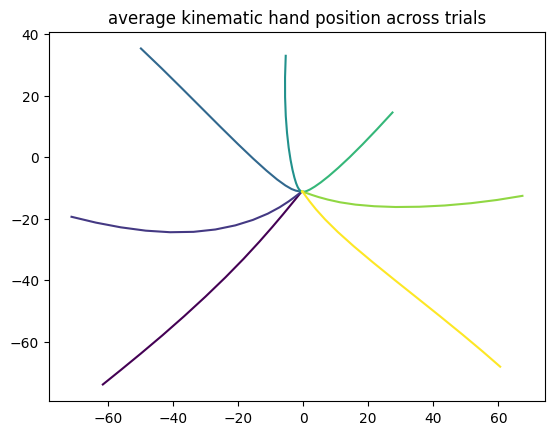

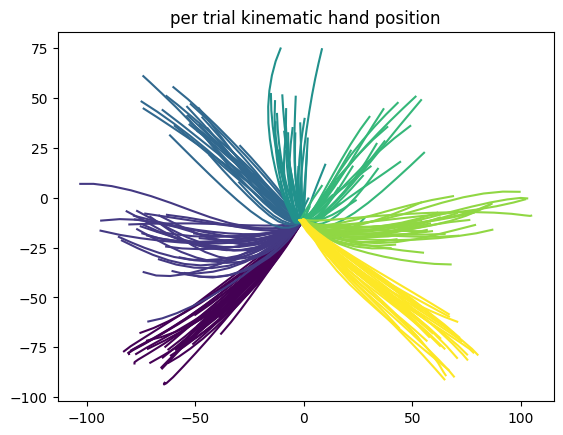

In [4]:
colors = pl.cm.viridis(np.linspace(0,1,7))

# plot average kinematic position across trials for a given session
K = kinematic_data[d]
plt.figure()
for c,cond in enumerate(conditions):   
    meh = np.dstack([K[t]['kinematics'] for t in K.keys() if K[t]['condition']==cond]).mean(2)        
    plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('average kinematic hand position across trials')

# plot kinematic position for each trials in a given session
plt.figure()
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['kinematics']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('per trial kinematic hand position')
# plt.savefig('./outputs/trial_kinematics_session{}.svg'.format(d))

# Decoding single session


### Decoding LFADS 

In [5]:
# loop over test trials
alpha = 1
dt = 20

K = kinematic_data[d]

X = []
Z = []
y = []
for tr in kinematic_data[d].keys():
    X.append(K[tr]['kinematics'][:,:-1])
    Z.append(K[tr]['lfads_factors'][:,:-1])
    y.append(K[tr]['condition'])
    
X = np.hstack(X)
Z = np.hstack(Z)
y = np.hstack(y)

X = X[:4,:] # they only took first four rows of kinematics
Z = np.vstack([Z,np.ones(Z.shape[1])])


out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
Lw = out[0].T


for tr in kinematic_data[d].keys():
    
    #trial_emb = emb[:,trial_indexes==t] # get trial embedding
    trial_emb = K[tr]['lfads_factors'][:,:-1] # get trial embedding
    trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial

    
    trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])

    
    # first time point of embedding
    neural = trial_emb[:,0]

    # empty array for decoding predictions
    trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
    trial_pred[:] = np.nan

    trial_pred[:2,0] = trial_kinematics[:2,0]

    # predict velocity 
    z  = np.matmul(Lw,neural); # decode
    trial_pred[[2,3],0] = z[[2,3]]
    trial_pred[4,0] = 1

    # loop over each time point in trial
    for nt in range(1,trial_kinematics.shape[1]):

        neural = trial_emb[:,nt] # next point of embedding
        z  = np.matmul(Lw,neural); # decode

        trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

        trial_pred[[2,3],nt] = z[[2,3]]
        trial_pred[4,nt] = 1
    
    kinematic_data[d][tr]['lfads_decoded'] = trial_pred


### Decoding MARBLE 

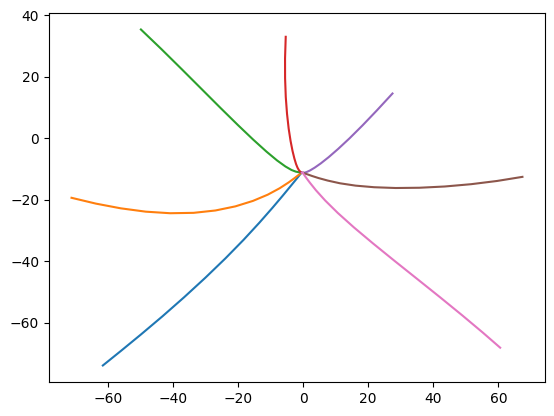

In [6]:

plt.figure()
for cond in conditions:   
    meh = np.dstack([K[t]['kinematics'] for t in K.keys() if K[t]['condition']==cond]).mean(2)        
    plt.plot(meh[0,:],meh[1,:])


In [7]:

# use the saved trial ids to match the embeddings to the kinematics
unique_trial_ids = list(dict.fromkeys(trial_ids[d].tolist()))
emb = embeddings[d]    
for t in unique_trial_ids:
    kinematic_data[d][t]['marble_emb'] = emb[trial_ids[d]==t,:]    

     
X = []
Z = []
y = []
for tr in kinematic_data[d].keys():
    X.append(K[tr]['kinematics'][:,:-1])
    Z.append(K[tr]['marble_emb'][:,:].T)
    y.append(K[tr]['condition'])
    
    
X = np.hstack(X)
Z = np.hstack(Z)
y = np.hstack(y)

X = X[:4,:] # they only took first four rows of kinematics
Z = np.vstack([Z,np.ones(Z.shape[1])])


out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
Lw = out[0].T

# loop over test trials
alpha = 1
dt = 20


for tr in kinematic_data[d].keys():
    
    #trial_emb = emb[:,trial_indexes==t] # get trial embedding
    trial_emb = K[tr]['marble_emb'][:,:].T # get trial embedding
    trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial

    
    trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])

    
    # first time point of embedding
    neural = trial_emb[:,0]

    # empty array for decoding predictions
    trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
    trial_pred[:] = np.nan

    trial_pred[:2,0] = trial_kinematics[:2,0]

    # predict velocity 
    z  = np.matmul(Lw,neural); # decode
    trial_pred[[2,3],0] = z[[2,3]]
    trial_pred[4,0] = 1


    # loop over each time point in trial
    for nt in range(1,trial_kinematics.shape[1]):

        neural = trial_emb[:,nt] # next point of embedding
        z  = np.matmul(Lw,neural); # decode

        trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

        trial_pred[[2,3],nt] = z[[2,3]]
        trial_pred[4,nt] = 1
    
    kinematic_data[d][tr]['marble_decoded'] = trial_pred


### Comparison of decoding with ground truth

Text(0.5, 1.0, 'LFADS')

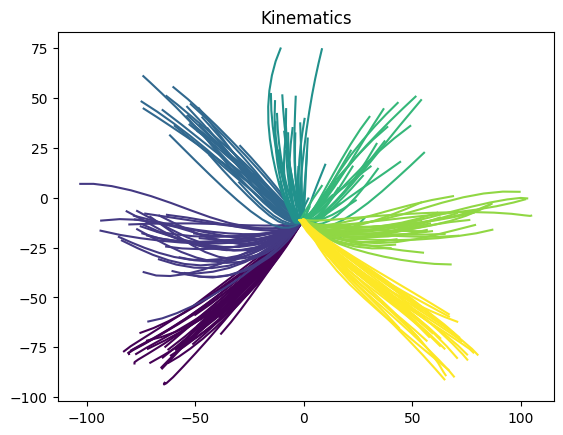

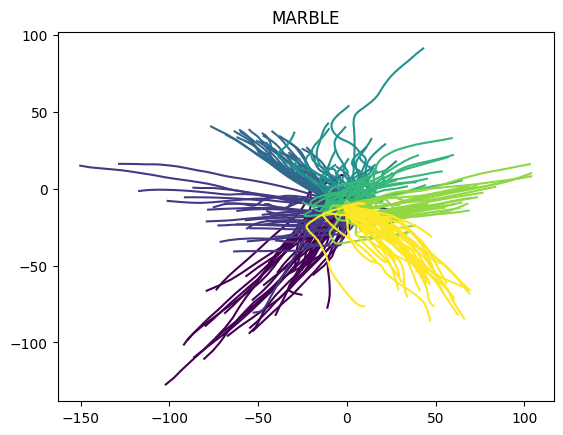

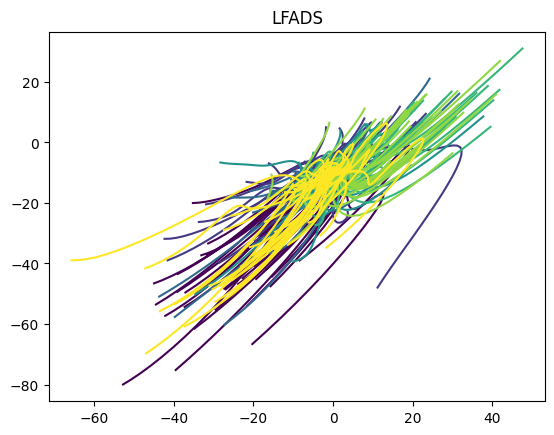

In [8]:
            
plt.figure()
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['kinematics']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('Kinematics')

plt.figure()
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['marble_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('MARBLE')
            
            
plt.figure()
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['lfads_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('LFADS')

# Decode across all sessions

Above we decoded for a single session. Lets now loop over every session and compute some quantitative comparisons with the ground truth kinematics.

In [9]:

# reload kinematic data
kinematic_data =  pickle.load(open('../data/kinematics.pkl','rb'))       

# define a function for computing R-squared of kinematics
def calcR2(data, model):
    datavar = sum((data-np.mean(data))**2);
    errorvar = sum((model-data)**2);
    r2 = 1-errorvar/datavar    
    return r2


First decode for LFADS embeddings across all sessions.

In [10]:
## run for lfads factors

# use 5-fold split of the data 
kf = KFold(n_splits=5, shuffle=True)

r2_lfads_vel = []; r2_lfads_pos = []

# loop over seessions
for d in kinematic_data.keys():
    K = kinematic_data[d]  
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(list(kinematic_data[d].keys()))):

        # training
        X = []
        Z = []
        y = []
        for tr in train_index:
            X.append(K[tr]['kinematics'][:,:-1])
            Z.append(K[tr]['lfads_factors'][:,:-1])
            y.append(K[tr]['condition'])

        X = np.hstack(X)
        Z = np.hstack(Z)
        y = np.hstack(y)

        X = X[:4,:] # they only took first four rows of kinematics
        Z = np.vstack([Z,np.ones(Z.shape[1])])

        # solve linear equations
        out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
        Lw = out[0].T


        # loop over test trials
        alpha = 1
        dt = 20

        for tr in test_index:

            #trial_emb = emb[:,trial_indexes==t] # get trial embedding
            trial_emb = K[tr]['lfads_factors'][:,:-1] # get trial embedding
            trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial


            trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])


            # first time point of embedding
            neural = trial_emb[:,0]

            # empty array for decoding predictions
            trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
            trial_pred[:] = np.nan

            trial_pred[:2,0] = trial_kinematics[:2,0]

            # predict velocity 
            z  = np.matmul(Lw,neural); # decode
            trial_pred[[2,3],0] = z[[2,3]]
            trial_pred[4,0] = 1


            # loop over each time point in trial
            for nt in range(1,trial_kinematics.shape[1]):

                neural = trial_emb[:,nt] # next point of embedding
                z  = np.matmul(Lw,neural); # decode

                trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

                trial_pred[[2,3],nt] = z[[2,3]]
                trial_pred[4,nt] = 1

            kinematic_data[d][tr]['lfads_decoded'] = trial_pred
            
    # r-squared velocity
    X = []
    Z = []
    for tr in list(kinematic_data[d].keys()):
        X.append(K[tr]['kinematics'][:,:-1])
        Z.append(K[tr]['lfads_decoded'][:,:])

    X = np.hstack(X)
    Z = np.hstack(Z)

    r2_lfads_vel.append(np.mean([calcR2(X[2,:], Z[2,:]), calcR2(X[3,:], Z[3,:])])) # mean of x and y velocity

    # r-squared pos
    X = []
    Z = []
    for tr in list(kinematic_data[d].keys()):
        X.append(K[tr]['kinematics'][:,:-1])
        Z.append(K[tr]['lfads_decoded'][:,:])

    X = np.hstack(X)
    Z = np.hstack(Z)

    r2_lfads_pos.append(np.mean([calcR2(X[0,:], Z[0,:]), calcR2(X[1,:], Z[1,:])])) # mean of x and y position

        

Lets now decode for MARBLE embeddings at every session.

In [11]:
## run for marble embedding

r2_marble_vel = []; r2_marble_pos = []

# loop over sessions
for d in range(len(embeddings)): 
    # use the saved trial ids to match the embeddings to the kinematics

    unique_trial_ids = np.array(list(dict.fromkeys(trial_ids[d].tolist())))

    emb = embeddings[d]    
    for t in unique_trial_ids:
        kinematic_data[d][t]['marble_emb'] = emb[trial_ids[d]==t,:]    

    K = kinematic_data[d]
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(unique_trial_ids)):
        
        # extracting trial ids for training and test
        train_index = unique_trial_ids[train_index]
        test_index = unique_trial_ids[test_index]

        # training
        X = []
        Z = []
        y = []
        for tr in train_index:
            X.append(K[tr]['kinematics'][:,:-1])
            Z.append(K[tr]['marble_emb'][:,:].T)
            y.append(K[tr]['condition'])


        X = np.hstack(X)
        Z = np.hstack(Z)
        y = np.hstack(y)

        X = X[:4,:] # they only took first four rows of kinematics
        Z = np.vstack([Z,np.ones(Z.shape[1])])


        out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
        Lw = out[0].T


        # loop over test trials
        alpha = 1
        dt = 20

        # looping over test samples
        for tr in test_index:

            #trial_emb = emb[:,trial_indexes==t] # get trial embedding
            trial_emb = K[tr]['marble_emb'][:,:].T # get trial embedding
            trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial


            trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])


            # first time point of embedding
            neural = trial_emb[:,0]

            # empty array for decoding predictions
            trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
            trial_pred[:] = np.nan

            trial_pred[:2,0] = trial_kinematics[:2,0]

            # predict velocity 
            z  = np.matmul(Lw,neural); # decode
            trial_pred[[2,3],0] = z[[2,3]]
            trial_pred[4,0] = 1


            # loop over each time point in trial
            for nt in range(1,trial_kinematics.shape[1]):

                neural = trial_emb[:,nt] # next point of embedding
                z  = np.matmul(Lw,neural); # decode

                trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

                trial_pred[[2,3],nt] = z[[2,3]]
                trial_pred[4,nt] = 1

            kinematic_data[d][tr]['marble_decoded'] = trial_pred        

    # r-squared velocity
    X = []
    Z = []
    for tr in list(unique_trial_ids):
        X.append(K[tr]['kinematics'][:,:-1])
        Z.append(K[tr]['marble_decoded'][:,:])

    X = np.hstack(X)
    Z = np.hstack(Z)

    r2_marble_vel.append(np.mean([calcR2(X[2,:], Z[2,:]), calcR2(X[3,:], Z[3,:])])) # mean of x and y velocity

    # r-squared pos
    X = []
    Z = []
    for tr in list(unique_trial_ids):
        X.append(K[tr]['kinematics'][:,:-1])
        Z.append(K[tr]['marble_decoded'][:,:])

    X = np.hstack(X)
    Z = np.hstack(Z)

    r2_marble_pos.append(np.mean([calcR2(X[0,:], Z[0,:]), calcR2(X[1,:], Z[1,:])])) # mean of x and y position

        

Lets now visualise the decoded kinematics for the same set of example sessions (Fig S7).

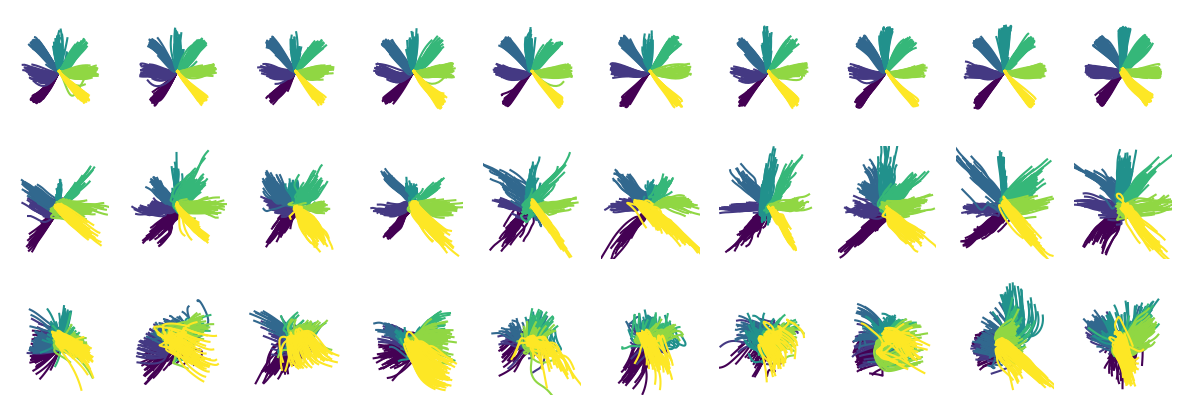

In [12]:
# chosen example sessions
examples = [5,6,8,11,14,15,18,23,26,32]

fig, ax = plt.subplots(3,len(examples),figsize=(15,5))

for i,d in enumerate(examples):
    
    sz = 140


    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                meh = kinematic_data[d][t]['kinematics']
                ax[0,i].plot(meh[0,:],meh[1,:],c=colors[c])


    ax[0,i].set_xlim([-sz, sz])
    ax[0,i].set_ylim([-sz, sz])
    ax[0,i].set_axis_off()

    unique_trial_ids = np.array(list(dict.fromkeys(trial_ids[d].tolist())))


    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                meh = kinematic_data[d][t]['marble_decoded']
                ax[1,i].plot(meh[0,:],meh[1,:],c=colors[c])
    ax[1,i].set_xlim([-sz, sz])
    ax[1,i].set_ylim([-sz, sz])
    ax[1,i].set_axis_off()


    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                meh = kinematic_data[d][t]['lfads_decoded']
                ax[2,i].plot(meh[0,:],meh[1,:],c=colors[c])
    ax[2,i].set_xlim([-sz, sz])
    ax[2,i].set_ylim([-sz, sz])
    ax[2,i].set_axis_off()

# plt.savefig('./outputs/decoding_session_examples.png')
    

How does the decoding accuracy of velocity between the two methods compare?

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

marble vs. LFADS: Wilcoxon test (paired samples), P_val:1.033e-03 Stat=2.210e+02


/home/robert/anaconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


(<AxesSubplot:xlabel='model', ylabel='accuracy'>,
 [<statannotations.Annotation.Annotation at 0x7fcbee5fa3a0>])

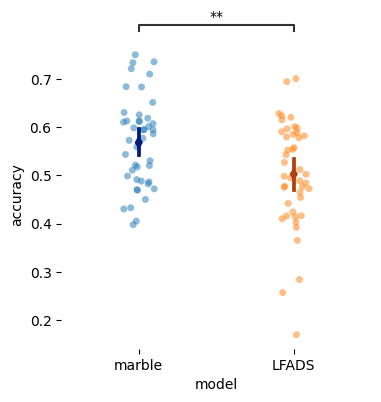

In [13]:
results = pd.DataFrame(data=np.vstack([ r2_marble_vel, r2_lfads_vel]).T,columns=['marble', 'LFADS'])
results = results.melt()
results.columns = ['model','accuracy']

import seaborn as sns
from statannotations.Annotator import Annotator

f, ax = plt.subplots(figsize=(4,4))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)


sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)

pairs=[("LFADS", "marble")]

annotator = Annotator(ax, pairs, data=results, x="model", y="accuracy",)
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()



We can also train a classifier to predict the movement? This tells us about the accuracy of decoding the position vectors.

In [14]:
kinematic_model_acc = []
marble_model_acc = []
lfads_model_acc = []

for d in range(len(embeddings)):           

    # fit classifier to kinematics
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['kinematics'][:2,:-1].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    clf = SVC().fit(X, y)
    kinematic_model_acc.append(clf.score(X, y))
    
    
    # evaluate model on marble decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['marble_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    marble_model_acc.append(clf.score(X, y))
    
    
    # evaluate model on lfads decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['lfads_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    lfads_model_acc.append(clf.score(X, y))

results = pd.DataFrame(data=np.vstack([ marble_model_acc, lfads_model_acc]).T,columns=['marble', 'LFADS'])

results = results.melt()
results.columns = ['model','accuracy']

<AxesSubplot:xlabel='model', ylabel='accuracy'>

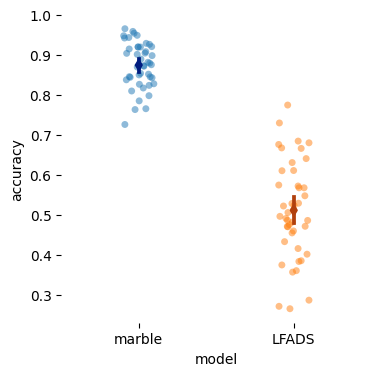

In [15]:
import seaborn as sns

f, ax = plt.subplots(figsize=(4,4))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)


sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)

#plt.savefig('./outputs/condition_prediction_accuracy.svg')